In [1]:
import xarray as xr
import geopandas as gpd
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from shapely.geometry import Polygon, MultiPolygon, MultiPoint
import matplotlib.pyplot as plt
from rasterio import features
from affine import Affine
from sklearn.cluster import AgglomerativeClustering

import FINE as fn
import FINE.spagat.dataset as spd
import FINE.spagat.representation as spr 
import FINE.IOManagement.xarray_io as xrio 

# Data and Shapefile

#### Gridded test data 

In [2]:
time_steps = 10
x_coordinates = 5
y_coordinates = 3

time = np.arange(time_steps)
x_locations = [1, 2, 3, 4, 5]
y_locations = [1, 2, 3]

In [ ]:
#capacity factor time series (USING MAKE BLOBS)
# test_data = np.zeros((x_coordinates, y_coordinates, time_steps))

# test_capfac_dataarray = xr.DataArray(test_data, 
#                                      coords=[x_locations, y_locations, time], 
#                                      dims=['x', 'y','time'])

#first region - 9 time series, x_coords:0,1,2, y_coords: 0,1,2
# first_region_data, first_region_labels = make_blobs(n_samples = 9, 
#                                                    centers = 4, 
#                                                    n_features = time_steps, 
#                                                    random_state = 0)  #, center_box=(0, 1)

# first_region_data = first_region_data.reshape(3,3,10)

# for i, x_location in enumerate(x_locations[:3]):
#     test_capfac_dataarray.loc[x_location,:,:] = first_region_data[i, :,:]
    
#second region - 6 time series, x_coords:3,4, y_coords: 0,1,2
# second_region_data, second_region_labels = make_blobs(n_samples = 6, 
#                                                    centers = 2, 
#                                                    n_features = time_steps, 
#                                                    random_state = 0)  #, center_box=(0, 1)

# second_region_data = second_region_data.reshape(2,3,10)

# for i, x_location in enumerate(x_locations[3:]):
#     test_capfac_dataarray.loc[x_location,:,:] = second_region_data[i, :,:]

In [31]:
#capacity factor time series 
test_capfac_dataarray = xr.DataArray(coords=[x_locations, y_locations, time], 
                                     dims=['x', 'y','time'])


In [55]:
test_capfac_dataarray.loc[[1, 2, 5], :, :] = [np.full((3, 10), 1) for x in range(3)]
test_capfac_dataarray.loc[3:4, :, :] = [np.full((3, 10), 2) for x in range(2)]

In [57]:
#capacities
test_data = np.ones((x_coordinates, y_coordinates))
test_capacity_dataarray = xr.DataArray(test_data, 
                                       coords=[x_locations, y_locations], 
                                       dims=['x', 'y'])
    

In [58]:
test_Dataset = xr.Dataset({'capacity': test_capacity_dataarray,
                            'capfac': test_capfac_dataarray}) 
test_Dataset

<xarray.Dataset>
Dimensions:   (time: 10, x: 5, y: 3)
Coordinates:
  * x         (x) int32 1 2 3 4 5
  * y         (y) int32 1 2 3
  * time      (time) int32 0 1 2 3 4 5 6 7 8 9
Data variables:
    capacity  (x, y) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0
    capfac    (x, y, time) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0

#### test shapefile 

In [59]:
polygon1 = Polygon([(0,0), (4,0), (4,4), (0,4)])
polygon2 = Polygon([(4,0), (7,0), (7,4), (4,4)])

test_geometries = [MultiPolygon([polygon1]),
                   MultiPolygon([polygon2])] 

df = pd.DataFrame({'region_ids': ['reg_01', 'reg_02']})

gdf = gpd.GeoDataFrame(df, geometry=test_geometries, crs=f'epsg:{3035}') 

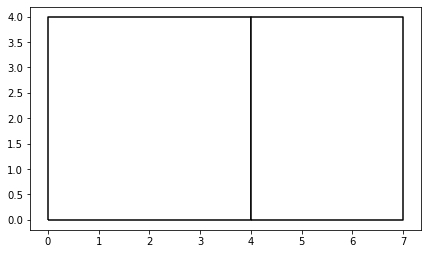

In [60]:
gdf.plot(figsize=(7, 7), color='white', edgecolor='black', linewidth = 1.5)

TEST_SHP_PATH = 'C:/Users/s.patil/Documents/code/fine/experiments/REPRESENTATION/InputData/Shapefiles'

gdf.to_file(TEST_SHP_PATH, layer = 'test_shp_representation') 

# Functions to convert girdded data into regional data based on given shapefile

In [61]:
def transform_from_latlon(lat, lon):
    """ input 1D array of lat / lon and output an Affine transformation
    """
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

In [62]:
def rasterize_geometry(geometry, coords, latitude='y', longitude='x'):
    
    transform = transform_from_latlon(coords[latitude], coords[longitude])
    out_shape = (len(coords[latitude]), len(coords[longitude]))
    
    raster = features.rasterize([geometry], 
                                out_shape=out_shape,
                                fill=np.nan, 
                                transform=transform,
                                dtype=float)
    

    return raster 

In [63]:
def add_shapes_from_shp(gridded_RE_ds, 
                        shp_path, 
                        index_col='region_ids', 
                        geometry_col='geometry',
                        longitude='x', 
                        latitude='y', 
                        region_description=None):

    #STEP 1. Read shapefile
    regions_shp = gpd.read_file(shp_path)
    
    #STEP 2. Add geometries 
    region_geometries = regions_shp[geometry_col]
    region_indices = regions_shp[index_col]
    
    if not region_description:
        region_description = index_col
        
    rasterized_RE_ds = gridded_RE_ds.expand_dims({region_description : region_indices})  
    
        
    # 2. rasterize each geometry and add it to new data_var "rasters"
    coords = rasterized_RE_ds.coords 
    
    rasterized_RE_ds['rasters'] = ([region_description, 'y', 'x'],
                                      [rasterize_geometry(geometry, 
                                                 coords, 
                                                 longitude=longitude, 
                                                 latitude=latitude)
                                       for geometry in regions_shp[geometry_col]])
    return rasterized_RE_ds

# Usage 

In [64]:
sds = spd.SpagatDataset()

sds.xr_ds_wind = test_Dataset

In [65]:
TEST_SHP_PATH = 'C:/Users/s.patil/Documents/code/fine/experiments/REPRESENTATION/InputData/Shapefiles/test_shp_representation.shp'

In [66]:
regional_ds_wind = add_shapes_from_shp(sds.xr_ds_wind, 
                                TEST_SHP_PATH, 
                                index_col='region_ids', 
                                geometry_col='geometry',
                                longitude='x', 
                                latitude='y')

In [67]:
regional_ds_wind

<xarray.Dataset>
Dimensions:     (region_ids: 2, time: 10, x: 5, y: 3)
Coordinates:
  * region_ids  (region_ids) object 'reg_01' 'reg_02'
  * x           (x) int32 1 2 3 4 5
  * y           (y) int32 1 2 3
  * time        (time) int32 0 1 2 3 4 5 6 7 8 9
Data variables:
    capacity    (region_ids, x, y) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    capfac      (region_ids, x, y, time) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    rasters     (region_ids, y, x) float64 1.0 1.0 1.0 nan ... nan nan 1.0 1.0

In [68]:
# subset = regional_ds_wind.where(regional_ds_wind.rasters[1:]) #Incase you want to send just a subset of regions 
# subset

# Representation Function

In [69]:
def represent_RE_technology(rasterized_RE_ds,
                            n_timeSeries_perRegion):
    '''
    Function represents RE time series and their corresponding capacities using time series clustering methods.
    Clustering method: agglomerative hierarchical clustering, Linkage criteria: Average 
    Distance measure used: Euclidean distance 

    '''
     
    #STEP 1. Create DataArrays to store the represented time series and capacities
    ## DataArray to store the represented time series
    #TODO: maybe instead of dataarrays, you can directly output a data dict for FINE here.
    
    time_steps = rasterized_RE_ds.coords["time"].values  #quickfix might be required - X.time.values = range(8760)
    region_ids = rasterized_RE_ds.coords["region_ids"].values

    n_regions = len(region_ids)
    n_timeSteps = len(time_steps)

    TS_ids = [f'TS_{i}' for i in range(n_timeSeries_perRegion)] #TODO: change TS to something else ?
    data = np.zeros((n_timeSteps, n_regions, n_timeSeries_perRegion))

    represented_timeSeries = xr.DataArray(data, [('time', time_steps),
                                                  ('region_ids', region_ids),
                                                  ('TS_ids', TS_ids)])

    ## DataArray to store the represented capacities
    data = np.zeros((len(region_ids), n_timeSeries_perRegion))

    represented_capacities = xr.DataArray(data, [('region_ids', region_ids),
                                                  ('TS_ids', TS_ids)])
    
    #STEP 2. Representation in every region...
    for region in region_ids:
        #STEP 2a. Get time series and capacities of current region 
        regional_ds = rasterized_RE_ds.sel(region_ids = region)
        regional_capfac_da = regional_ds.capfac.where(regional_ds.rasters == 1)
        regional_capacity_da = regional_ds.capacity.where(regional_ds.rasters == 1)

        #STEP 2b. Preprocess regional capfac and capacity dataArrays 

        #STEP 2b (i). Restructure data
        #INFO: The clustering model, takes <= 2 dimensions. So, x and y coordinates are fused 
        # Transposing dimensions to make sure clustering is performed along x_y dimension (i.e., space not time)
        regional_capfac_da = regional_capfac_da.stack(x_y = ['x', 'y']) 
        regional_capfac_da = regional_capfac_da.transpose(transpose_coords= True) 

        regional_capacity_da = regional_capacity_da.stack(x_y = ['x', 'y'])
        regional_capacity_da = regional_capacity_da.transpose(transpose_coords= True)

        #STEP 2b (ii). Remove all time series with 0 values 
        regional_capfac_da = regional_capfac_da.where(regional_capacity_da > 0)
        regional_capacity_da = regional_capacity_da.where(regional_capacity_da > 0)

        #STEP 2b (iii). Drop NAs 
        regional_capfac_da = regional_capfac_da.dropna(dim='x_y')
        regional_capacity_da = regional_capacity_da.dropna(dim='x_y')

        #Print out number of time series in the region 
        n_ts = len(regional_capfac_da['x_y'].values)
        print(f'Number of time series in {region}: {n_ts}')

        #STEP 2c. Get power curves from capacity factor time series and capacities 
        region_power_da = regional_capacity_da * regional_capfac_da

        #STEP 2d. Clustering  
        agg_cluster = AgglomerativeClustering(n_clusters=n_timeSeries_perRegion, 
                                              affinity="euclidean",  
                                              linkage="average")
        agglomerative_model = agg_cluster.fit(regional_capfac_da)

        #STEP 2e. Aggregation
        for i in range(np.unique(agglomerative_model.labels_).shape[0]):
            ## Aggregate capacities 
            cluster_capacity = regional_capacity_da[agglomerative_model.labels_ == i]
            cluster_capacity_total = cluster_capacity.sum(dim = 'x_y').values

            represented_capacities.loc[region, TS_ids[i]] = cluster_capacity_total

            #aggregate capacity factor 
            cluster_power = region_power_da[agglomerative_model.labels_ == i]
            cluster_power_total = cluster_power.sum(dim = 'x_y').values
            cluster_capfac_total = cluster_power_total/cluster_capacity_total

            represented_timeSeries.loc[:,region, TS_ids[i]] = cluster_capfac_total
    
    
            
    return represented_timeSeries, represented_capacities 